In [ ]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

from PIL import Image

import matplotlib.pyplot as plt
import zipfile
from keras.utils import load_img

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013 

zip_ref = zipfile.ZipFile('fer2013.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/fer2013') # Extracts the files into the /fer2013 folder
zip_ref.close()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 76% 46.0M/60.3M [00:00<00:00, 139MB/s]
100% 60.3M/60.3M [00:00<00:00, 142MB/s]


In [ ]:
train_path = "/fer2013/train/"
test_path = "/fer2013/test/"

print(os.listdir(test_path))
print(os.listdir(train_path))

['disgust', 'surprise', 'happy', 'fear', 'neutral', 'sad', 'angry']
['disgust', 'surprise', 'happy', 'fear', 'neutral', 'sad', 'angry']


In [ ]:
row, col = 48, 48
classes = 7

def count(path, set_):
    dict_ = {}
    for emotion in os.listdir(path):
        dir_ = path + emotion
        dict_[emotion] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count(train_path, 'train')
test_count = count(test_path, 'test')

print(train_count)
print(test_count)

       disgust  surprise  happy  fear  neutral   sad  angry
train      436      3171   7215  4097     4965  4830   3995
      disgust  surprise  happy  fear  neutral   sad  angry
test      111       831   1774  1024     1233  1247    958


<Axes: >

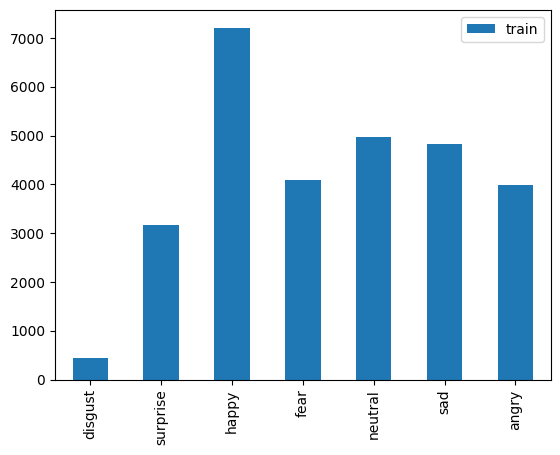

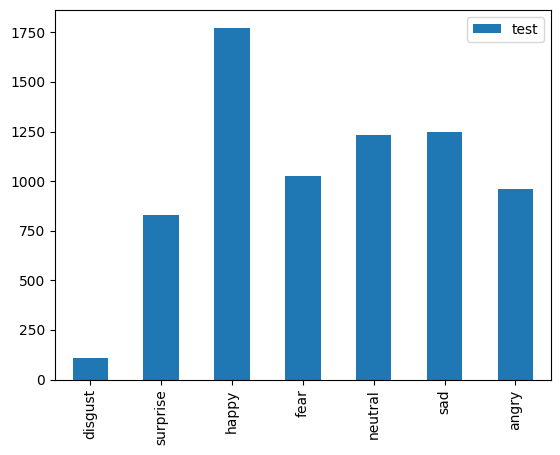

In [ ]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

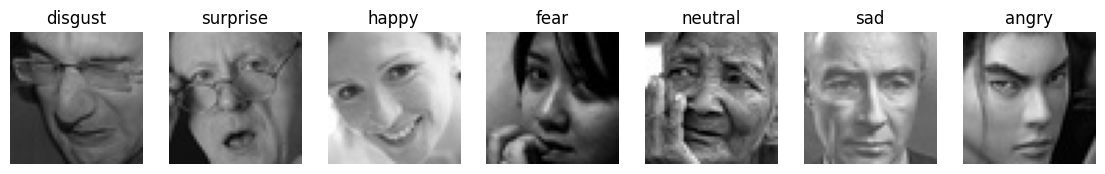

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for emotion in os.listdir(train_path):
    img = load_img((train_path + emotion +'/'+ os.listdir(train_path + emotion)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

training_set.class_indices


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
def get_model(input_size, classes=7, act = 'relu'):
    #Initialising the CNN
    model = tf.keras.models.Sequential()   

    # 2 layers
    model.add(Conv2D(32,(3,3), activation = act, padding='valid', input_shape = input_size)) # Convolutional layers
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid')) # to reduce size of image

    model.add(Conv2D(64,(3,3), activation = act, padding='valid'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
    model.add(Flatten()) # L2 

    # Dense layer with 7 neurons (one for each class)
    model.add(Dense(classes, activation='softmax'))

    #Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
CNN_ReLU = get_model((row,col,1), classes, 'relu')
CNN_ReLU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 7)                 4

In [ ]:
# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)


In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist_ReLU = CNN_ReLU.fit(x=training_set,
                 validation_data=test_set,
                 epochs=20,
                 callbacks=[checkpoint_callback],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 1.8060 - accuracy: 0.2530
Epoch 1: val_accuracy improved from -inf to 0.26158, saving model to model_weights.h5
448/448 [==============================] - 110s 243ms/step - loss: 1.8060 - accuracy: 0.2530 - val_loss: 1.7562 - val_accuracy: 0.2616
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 1.7290 - accuracy: 0.3033
Epoch 2: val_accuracy improved from 0.26158 to 0.33845, saving model to model_weights.h5
448/448 [==============================] - 110s 246ms/step - loss: 1.7290 - accuracy: 0.3033 - val_loss: 1.6808 - val_accuracy: 0.3384
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 1.6869 - accuracy: 0.3315
Epoch 3: val_accuracy improved from 0.33845 to 0.37291, saving model to model_weights.h5
448/448 [==============================] - 113s 251ms/step - loss: 1.6869 - accuracy: 0.3315 - val_loss: 1.6377 - val_accuracy: 0.3729
Epoch 4/20
448/448 [=======================

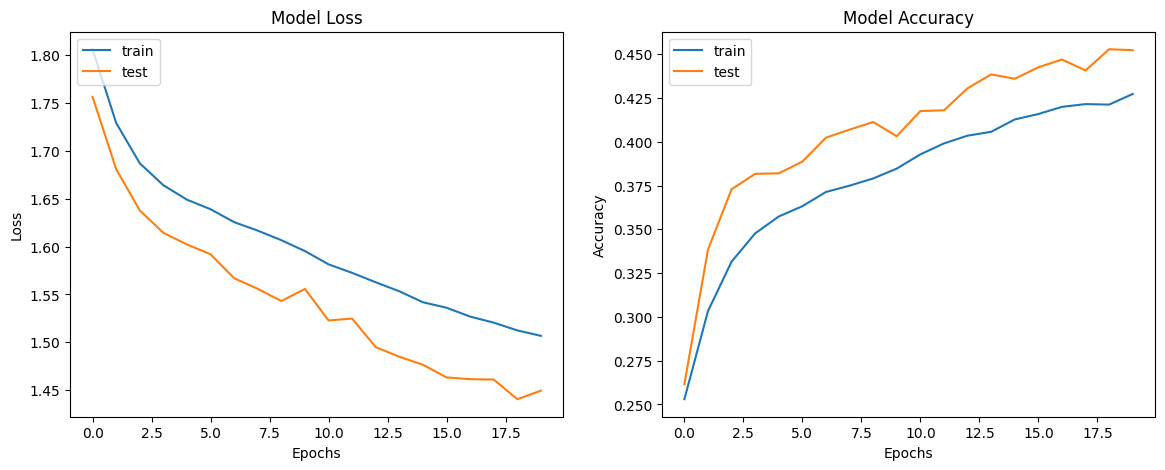

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist_ReLU.history['accuracy'])
plt.plot(hist_ReLU.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist_ReLU.history['loss'])
plt.plot(hist_ReLU.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accuracy = CNN_ReLU.evaluate(training_set)
test_loss, test_accuracy = CNN_ReLU.evaluate(test_set)
print("Train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

113/113 [==============================] - 8s 69ms/step - loss: 1.4496 - accuracy: 0.4521
Train accuracy = 42.03 , Test accuracy = 45.21


449/449 [==============================] - 39s 86ms/step
Training Set Confusion Matrix
[[ 340    0  540 1654  635  485  341]
 [  32    0   68  190   64   45   37]
 [ 332    0  550 1734  628  496  357]
 [ 615    0  972 3009 1114  880  625]
 [ 398    1  682 2076  770  574  464]
 [ 394    0  648 2085  764  535  404]
 [ 265    0  423 1290  499  382  312]]
Training Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.09      0.11      3995
     disgust       0.00      0.00      0.00       436
        fear       0.14      0.13      0.14      4097
       happy       0.25      0.42      0.31      7215
     neutral       0.17      0.16      0.16      4965
         sad       0.16      0.11      0.13      4830
    surprise       0.12      0.10      0.11      3171

    accuracy                           0.19     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.19      0.18     28709



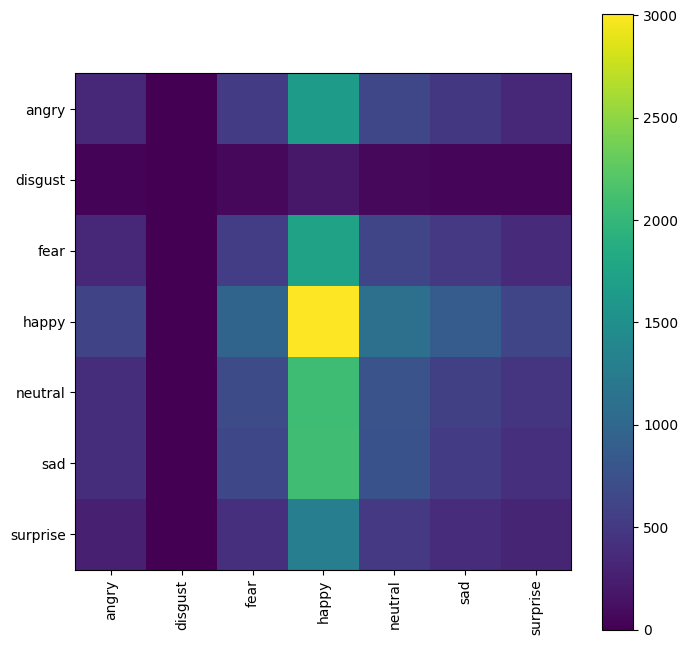

In [ ]:
y_pred = CNN_ReLU.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Training Set Confusion Matrix')
print(cm_train)
print('Training Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)